In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e12/sample_submission.csv
/kaggle/input/playground-series-s4e12/train.csv
/kaggle/input/playground-series-s4e12/test.csv


# 1.Importing libraries and dataset


In [2]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn models for Regression
from sklearn.ensemble import (
    AdaBoostRegressor,
    BaggingRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor,
    RandomForestRegressor,
    VotingRegressor,
)
from sklearn.linear_model import (
    Ridge,
    LinearRegression,
)
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)
from sklearn.model_selection import (
    KFold,
    cross_val_score,
    train_test_split,
)
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

# Other machine learning libraries
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Preprocessing and pipelines
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import VotingRegressor

In [3]:
#Importing dataset
train = pd.read_csv('/kaggle/input/playground-series-s4e12/train.csv', parse_dates=['Policy Start Date'])
test = pd.read_csv('/kaggle/input/playground-series-s4e12/test.csv',parse_dates=['Policy Start Date'])

# 2.EDA

In [4]:
styled_df = train.head().style.set_properties(**{"background-color": "#f9f9f9", "color": "#333333", "border": "1px solid #ccc", "font-weight": "normal"}).set_table_styles([{"selector": "th", "props": [("background-color", "#1976d2"), ("color", "white"), ("font-weight", "bold")]}]).format(precision=2)
styled_df

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.00,Female,10049.00,Married,1.00,Bachelor's,Self-Employed,22.60,Urban,Premium,2.00,17.00,372.00,5.00,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.00
1,1,39.00,Female,31678.00,Divorced,3.00,Master's,nan,15.57,Rural,Comprehensive,1.00,12.00,694.00,2.00,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.00
2,2,23.00,Male,25602.00,Divorced,3.00,High School,Self-Employed,47.18,Suburban,Premium,1.00,14.00,nan,3.00,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.00
3,3,21.00,Male,141855.00,Married,2.00,Bachelor's,nan,10.94,Rural,Basic,1.00,0.00,367.00,1.00,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.00
4,4,21.00,Male,39651.00,Single,1.00,Bachelor's,Self-Employed,20.38,Rural,Premium,0.00,8.00,598.00,4.00,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.00


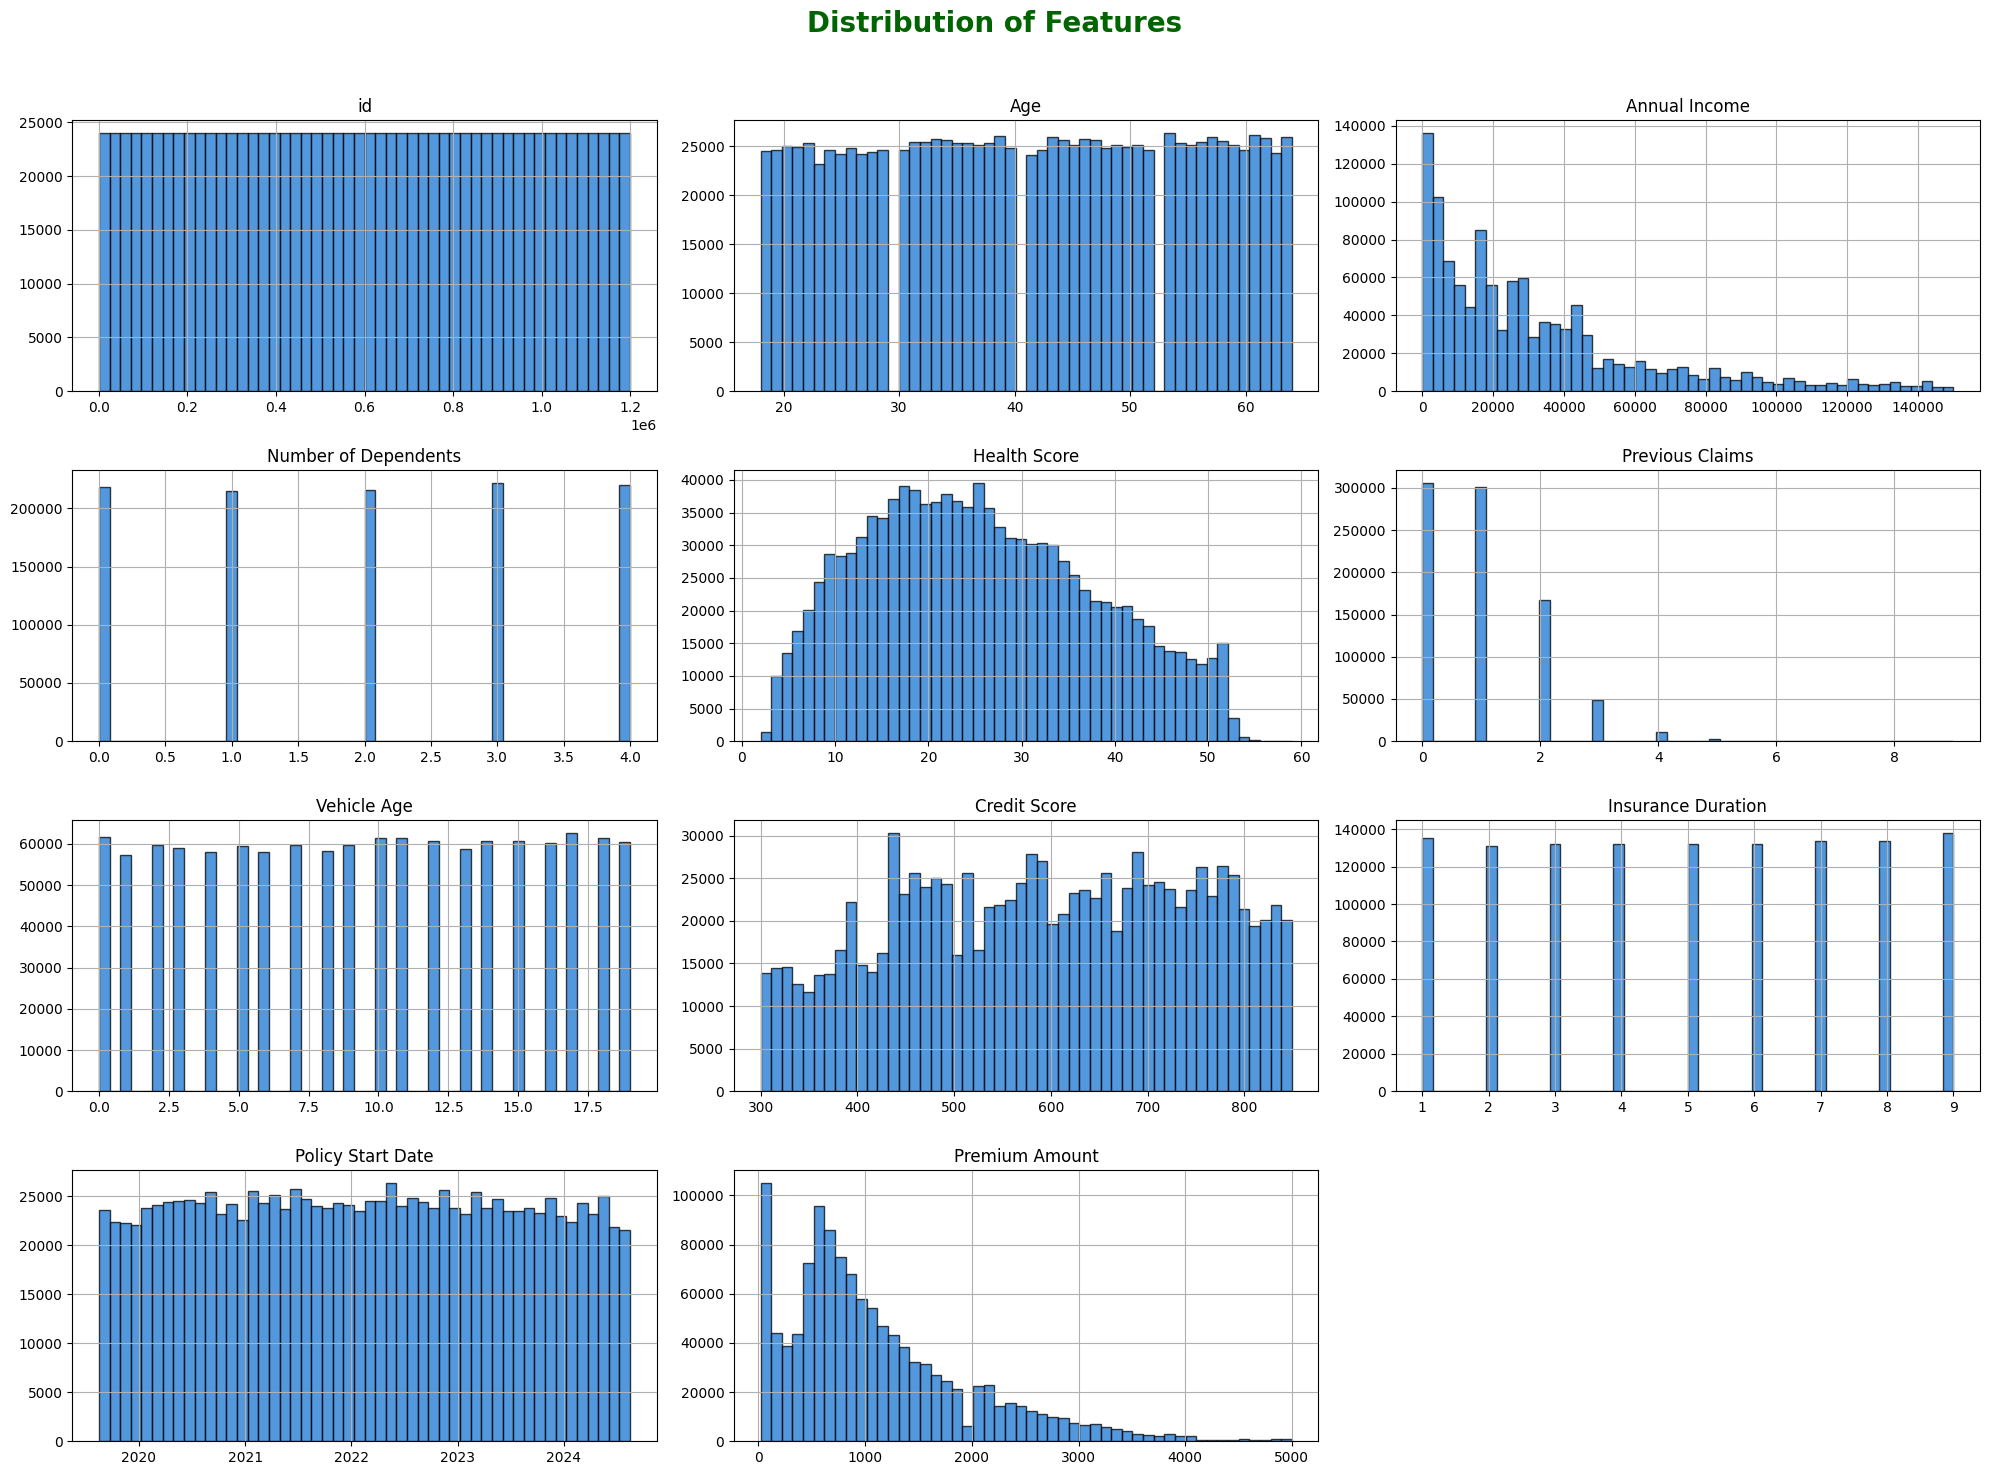

In [5]:
train.hist(
    bins=50, 
    figsize=(20, 15), 
    color='#1976d2', 
    edgecolor='black',
    alpha=0.75
)

# Add global title and adjust layout
plt.suptitle("Distribution of Features", fontsize=20, fontweight='bold', color='darkgreen')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [6]:
#For numerical variables, we can use the describe method to understand the value range and identify outliers.
train.describe().style.format(precision=2).background_gradient(cmap="Blues")

,id,Age,Annual Income,Number of Dependents,Health Score,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Premium Amount
count,1200000.00,1181295.00,1155051.00,1090328.00,1125924.00,835971.00,1199994.00,1062118.00,1199999.00,1200000,1200000.00
mean,599999.50,41.15,32745.22,2.01,25.61,1.00,9.57,592.92,5.02,2022-02-13 05:06:30.972380672,1102.54
min,0.00,18.00,1.00,0.00,2.01,0.00,0.00,300.00,1.00,2019-08-17 15:21:39.080371,20.00
25%,299999.75,30.00,8001.00,1.00,15.92,0.00,5.00,468.00,3.00,2020-11-20 15:21:39.121168896,514.00
50%,599999.50,41.00,23911.00,2.00,24.58,1.00,10.00,595.00,5.00,2022-02-14 15:21:39.151731968,872.00
75%,899999.25,53.00,44634.00,3.00,34.53,2.00,15.00,721.00,7.00,2023-05-06 15:21:39.182597120,1509.00
max,1199999.00,64.00,149997.00,4.00,58.98,9.00,19.00,849.00,9.00,2024-08-15 15:21:39.287115,4999.00
std,346410.31,13.54,32179.51,1.42,12.20,0.98,5.78,149.98,2.59,nan,865.00


In [19]:
# Calculate 'Policy_days'
train['Policy_days'] = (pd.Timestamp.today() - train['Policy Start Date']).dt.days
test['Policy_days'] = (pd.Timestamp.today() - test['Policy Start Date']).dt.days

# Drop the 'Policy Start Date' column
train_1 = train.drop(columns=['Policy Start Date']).reset_index()
test_1 = test.drop(columns=['Policy Start Date']).reset_index()


In [8]:
X = train_1.drop(columns=['Premium Amount'])
y = train_1['Premium Amount']


In [9]:
# Separating numerical and object columns 
def separate_columns(df):
    cat_col = [col for col in df.columns if df[col].dtype == 'object']
    num_col = [col for col in df.columns if df[col].dtype != 'object']
    return cat_col, num_col

cat_col, num_col = separate_columns(X)

print('Categorical datatype columns include: \n', cat_col)
print('Numerical datatype columns include: \n', num_col)


Categorical datatype columns include: 
 ['Gender', 'Marital Status', 'Education Level', 'Occupation', 'Location', 'Policy Type', 'Customer Feedback', 'Smoking Status', 'Exercise Frequency', 'Property Type']
Numerical datatype columns include: 
 ['index', 'id', 'Age', 'Annual Income', 'Number of Dependents', 'Health Score', 'Previous Claims', 'Vehicle Age', 'Credit Score', 'Insurance Duration', 'Policy_days']


In [10]:
#Creating categocail and numerical pipeline
numerical_pipeline = make_pipeline(SimpleImputer(strategy='mean'),StandardScaler())
categorical_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder())

In [20]:
# Combine them using ColumnTransformer
def create_preprocessor(numerical_pipeline, categorical_pipeline, num_col, cat_col):
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_pipeline, num_col),
            ('cat', categorical_pipeline, cat_col)
        ]
    )
    return preprocessor

# Create the preprocessor using the function
preprocessor = create_preprocessor(numerical_pipeline, categorical_pipeline, num_col, cat_col)

# Apply preprocessing to the training 
train_temp = preprocessor.fit_transform(X)
test_temp = preprocessor.fit_transform(test_1)


# 3.Modeling 

In [12]:
X_train,X_test,y_train,y_test = train_test_split(train_temp,y,test_size=0.2,random_state=21)

In [14]:
models = {
    "AdaBoost": AdaBoostRegressor(),
    "Bagging": BaggingRegressor(),
    "ExtraTrees": ExtraTreesRegressor(),
    "GradientBoosting": GradientBoostingRegressor(),
    "HistGradientBoosting": HistGradientBoostingRegressor(),
    "RandomForest": RandomForestRegressor()
}

In [ ]:
# Iterate over the models
for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))
    print(f"RMSLE for {model_name}: {rmsle}")


Training AdaBoost...
RMSLE for AdaBoost: 1.2751399491915507
Training Bagging...
RMSLE for Bagging: 1.1714456798658928
Training ExtraTrees...
RMSLE for ExtraTrees: 1.165501726703395
Training GradientBoosting...
RMSLE for GradientBoosting: 1.1564516319052955
Training HistGradientBoosting...
RMSLE for HistGradientBoosting: 1.1405658843345499
Training RandomForest...


In [ ]:
# Create the VotingRegressor using the models
voting_model = VotingRegressor(estimators=[(name, model) for name, model in models.items()])
voting_model.fit(X_train, y_train)
y_pred_1 = voting_model.predict(X_test)

In [17]:
rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred_1))
print(f"RMSLE for VotingRegressor: {rmsle}")

RMSLE for VotingRegressor: 1.175206769883883


In [18]:
import joblib

# Save the model to a file
joblib.dump(voting_model, "voting_regressor_model.pkl")
print("VotingRegressor model saved as 'voting_regressor_model.pkl'.")


VotingRegressor model saved as 'voting_regressor_model.pkl'.


In [22]:
y_final = voting_model.predict(test_temp)